# Machine Learning for Textual Data - Donald Trump's Tweets
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

07.05.2019

--------------------------------------------------------------------------------------------

# Project plan
Two models: Word count/frequency (LDA) and word2vec


In [1]:
import sys
print(sys.executable)
print(sys.version)

/usr/local/Cellar/python/3.7.2_2/bin/python3.7
3.7.2 (default, Feb 12 2019, 08:15:36) 
[Clang 10.0.0 (clang-1000.11.45.5)]


## 0. Setup

In [2]:
# import functions
import json
import os
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandersteeb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data import

In [4]:
import requests, zipfile, io
old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"
new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"

def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [20]:
path = "data"
df = pd.DataFrame()  


testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    print(testament)
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path,"r", encoding="utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index=True)
                
df.columns = ["text", "testament", "book", "file", "path"]

#df = df.sort_values("book","file")
#df.reset_index(drop=True, inplace=True)

Old Testament
New Testament


In [21]:
df.sample(1)

text  \
827  1 Then Joseph went to Pharaoh, and said, My father and my brothers with their flocks and their herds and all they have, are come from Canaan, and are now in the land of Goshen.\n2 And he took five of his brothers to Pharaoh.\n3 And Pharaoh said to them, What is your business? And they said, Your servants are keepers of sheep, as our fathers were before us.\n4 And they said to Pharaoh, We have come to make a living in this land, because we have no grass for our flocks in the land of Canaan; so now let your servants make a place for themselves in the land of Goshen.\n5 And Pharaoh said to Joseph, Let them have the land of Goshen; and if there are any able men among them, put them over my cattle.\n6 And Jacob and his sons came to Joseph in Egypt, and when word of it came to the ears of Pharaoh, king of Egypt, he said to Joseph, Your father and brothers have come to you; all the land of Egypt is before you; let your father and your brothers have the best of the land for their resting-place.\n7 Then Joseph made his father Jacob come before Pharaoh, and Jacob gave him his blessing.\n8 And Pharaoh said to him, How old are you?\n9 And Jacob said, The years of my wanderings have been a hundred and thirty; small in number and full of sorrow have been the years of my life, and less than the years of the wanderings of my fathers.\n10 And Jacob gave Pharaoh his blessing, and went out from before him.\n11 And Joseph made a place for his father and his brothers, and gave them a heritage in the land of Egypt, in the best of the land, the land of Rameses, as Pharaoh had given orders.\n12 And Joseph took care of his father and his brothers and all his father's people, giving them food for the needs of their families.\n13 Now there was no food to be had in all the land, so that all Egypt and Canaan were wasted from need of food.\n14 And all the money in Egypt and in the land of Canaan which had been given for grain, came into the hands of Joseph: and he put it in Pharaoh's house.\n15 And when all the money in Egypt and Canaan was gone, the Egyptians came to Joseph, and said, Give us bread; would you have us come to destruction before your eyes? for we have no more money.\n16 And Joseph said, Give me your cattle; I will give you grain in exchange for your cattle if your money is all gone.\n17 So they took their cattle to Joseph and he gave them bread in exchange for their horses and flocks and herds and asses, so all that year he gave them food in exchange for their cattle.\n18 And when that year was ended, they came to him in the second year, and said, We may not keep it from our lord's knowledge that all our money is gone, and all the herds of cattle are my lord's; there is nothing more to give my lord but our bodies and our land;\n19 Are we to come to destruction before your eyes, we and our land? take us and our land and give us bread; and we and our land will be servants to Pharaoh; and give us seed so that we may have life and the land may not become waste.\n20 So Joseph got all the land in Egypt for Pharaoh; for every Egyptian gave up his land in exchange for food, because of their great need; so all the land became Pharaoh's.\n21 And as for the people, he made servants of them, town by town, from one end of Egypt to the other.\n22 Only he did not take the land of the priests, for the priests had their food given them by Pharaoh, and having what Pharaoh gave them, they had no need to give up their land.\n23 Then Joseph said to the people, I have made you and your land this day the property of Pharaoh; here is seed for you to put in your fields.\n24 And when the grain is cut, you are to give a fifth part to Pharaoh, and four parts will be yours for seed and food, and for your families and your little ones.\n25 And they said to him, Truly you have kept us from death; may we have grace in your eyes, and we will be Pharaoh's servants.\n26 Then Joseph made a law which is in force to this day, that Pharaoh was to have the fifth part

## 2. Data cleaning

Data cleaning: Stemming, tokenization, see other documentation
Data visualisation (eg wordcloud)
Data inspection

In [22]:
def preprocessor(text):
    '''removing all punctuation, non-letter characters and white spaces'''
    text.strip()
    text = (re.sub('[\W]+', ' ', text.lower()))      #remove non-word characters and make text lowercase
    text = (re.sub('[\d]+', '', text))               #to remove numbers [0-9]
    text = (re.sub('\n', ' ', text))

    return text.strip()

def tokenizer(text):
    '''split text into single words and return a list of these words'''
    return text.split()

def remove_stopwords(text):
    stop = stopwords.words('english')
    words = [word for word in text.split()]
    stopremoved = [w for w in words if w not in stop]
    return ' '.join(stopremoved)

def tokenizer_porter(text):
    '''Porter stemmer - split text and convert all words back to 
    their stem, e.g. running -> run, return a list of the stemmed words'''
    
    stop = stopwords.words('english')
    porter = PorterStemmer()
    
    stem = [porter.stem(word) for word in text.split()]
    stopremoved = [w for w in stem if w not in stop] #removing common stop words as downloaded from nltk package
    return " ".join(stopremoved)

In [24]:
pd.set_option('display.max_colwidth', -1)
#df.head()

In [10]:
#wordcloud_df.head()

In [23]:
#apply preprocessor for Wordcloud and merge all preprocessed speeches to one text
wordcloud_df = df['text'].apply(preprocessor)
wordcloud_df = wordcloud_df.apply(remove_stopwords)

full_text = ''
for text in wordcloud_df:
    full_text += text

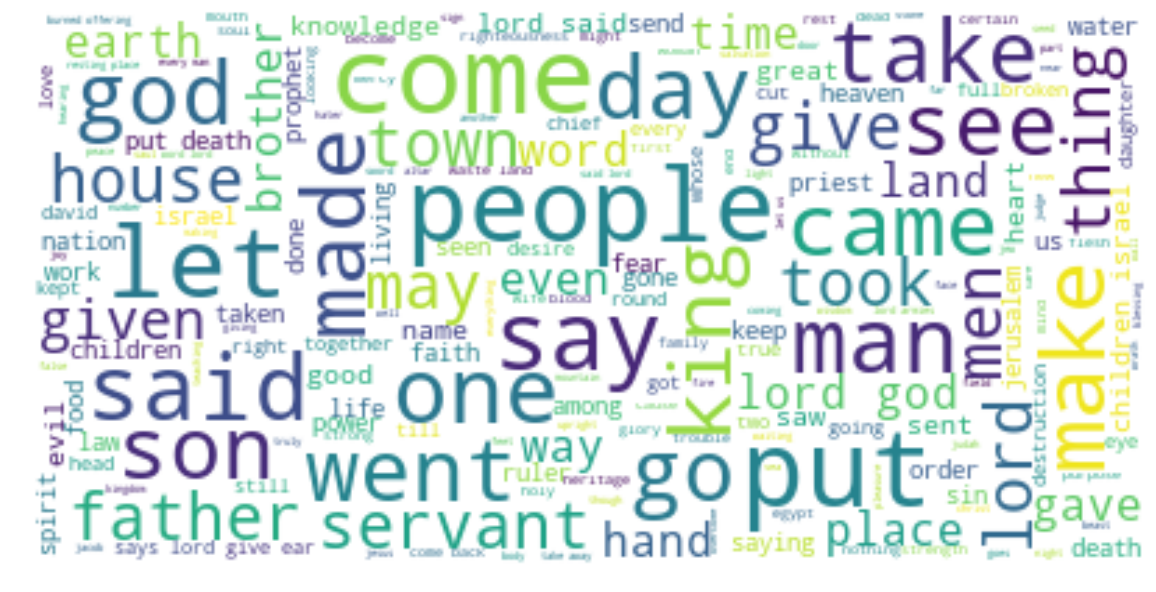

In [25]:
# generate word cloud 
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Model 1 - LDA

see documentation - Elisa 

In [26]:
# apply preprocessor for LDA

# apply preprocessor to speeches in data frame
df['cleaned'] = df['text']
df['cleaned'] = df['cleaned'].apply(preprocessor)

#Processing documents into tokens (incl. stemming and removing stopwords)
df['cleaned'] = df['cleaned'].apply(tokenizer_porter)

In [63]:
#Transformation Into Feature Vectors that count how often words appear in different speeches
count = CountVectorizer(stop_words="english", max_df=0.8, max_features=50_000)

for testament in testaments:
    text = df.loc[df['testament'] == testament,"text"]
    X = count.fit_transform(text)  #sparse matrix
    
    #fit LDA 
    lda = LatentDirichletAllocation(n_components=3, random_state=1000, learning_method='batch')
    X_topics = lda.fit_transform(X)

    lda.components_.shape
    #print 5 most important words of every topic
    print(testament)
    print("The five most important words of three topics are:")
    print()
    n_top_words = 5
    feature_names = count.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i]
        for i in topic.argsort()\
            [:-n_top_words - 1:-1]]))
    print()
    print()

Old Testament
The five most important words of three topics are:

Topic 1:
come god let make man
Topic 2:
children offering sons son moses
Topic 3:
said king went israel came


New Testament
The five most important words of three topics are:

Topic 1:
said came jesus went say
Topic 2:
christ faith lord good love
Topic 3:
son earth heaven great came




In [65]:
df['cleaned']

0       spring time king go war joab went head arm forc made wast land ammonit put hi men posit befor rabbah shut david wa still jerusalem joab took rabbah made wast david took crown milcom hi head weight wa talent gold stone great price wa put david head took great store good town took peopl town put work wood cut instrument iron grain crusher axe thi town children ammon david peopl went back jerusalem thi wa war philistin gezer sibbecai hushathit put death sippai one offspr rephaim overcom wa war philistin elhanan son jair put death lahmi brother goliath gittit stem whose spear wa like cloth worker rod wa war gath wa veri tall man twenti four finger toe six finger hi hand six toe hi feet wa one offspr rephaim put shame israel jonathan son shimea david brother put death offspr rephaim gath came death hand david hi servant                                                                                                                                                                      

## 4. Model 2 - Word2vec

on hold - Alex

## 5. Results